The study presents a neural network architecture capable of accurately classifying protein organelle localization labels with a test and training accuracy of 95 percent. The proposed model processes input as three-dimensional data, with each dimension representing a color filter (red, blue, yellow, and green). As a result, the input to the neural network is represented as (samples, 2, 90, 90, 3), where the number 2 corresponds to the two types of input data used in the proposed structure - RGB images and images captured using a yellow filter.

##Getting Datasets

In [1]:
import os

if os.path.isfile('/root/.kaggle/kaggle.json'):
    print('kaggle.json file exists in /root/.kaggle directory')
else:
    print('kaggle.json file does not exist in /root/.kaggle directory')


kaggle.json file exists in /root/.kaggle directory


In [2]:
!pip install -q kaggle

In [3]:


os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

!cp kaggle.json ~/.kaggle/



In [4]:
!kaggle competitions download -c human-protein-atlas-image-classification

human-protein-atlas-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib as p
import cv2

In [6]:
df_folder= "/content/train"

df_obj= p.Path(df_folder)
df_obj

PosixPath('/content/train')

In [7]:
df_img = list(df_obj.glob("*.*"))

len(df_img)


124288

In [8]:
df_csv= pd.read_csv("/content/train.csv")
df_csv.head(10)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
5,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0
6,0020af02-bbba-11e8-b2ba-ac1f6b6435d0,25 2
7,002679c2-bbb6-11e8-b2ba-ac1f6b6435d0,0
8,00285ce4-bba0-11e8-b2b9-ac1f6b6435d0,2 0
9,002daad6-bbc9-11e8-b2bc-ac1f6b6435d0,7


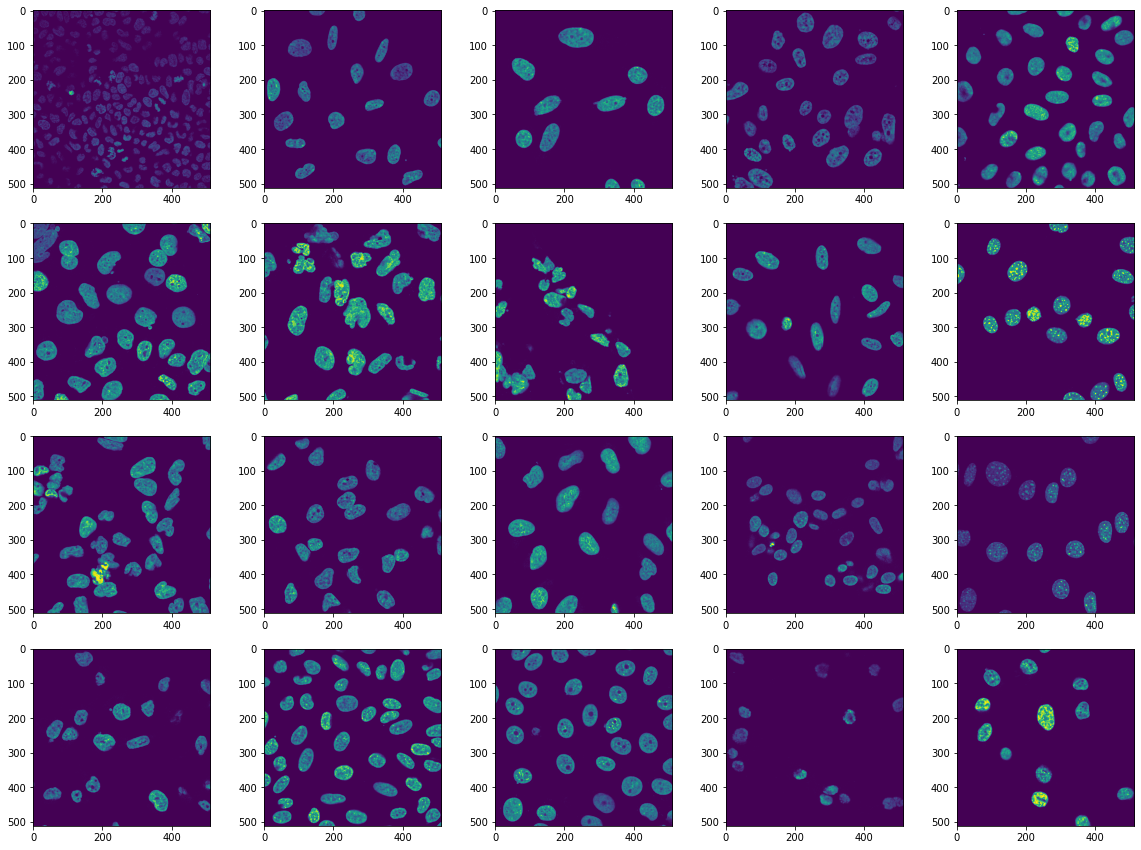

In [9]:
IDs = df_csv['Id']
plt.figure(figsize=(20, 15))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    for color in ['red', 'green', 'blue']:
        image_path = "train/{}_{}.png".format(str(IDs[i]), color)
        image = cv2.imread(image_path, 0)
        plt.imshow(image)
plt.show()


### Grayscale plt

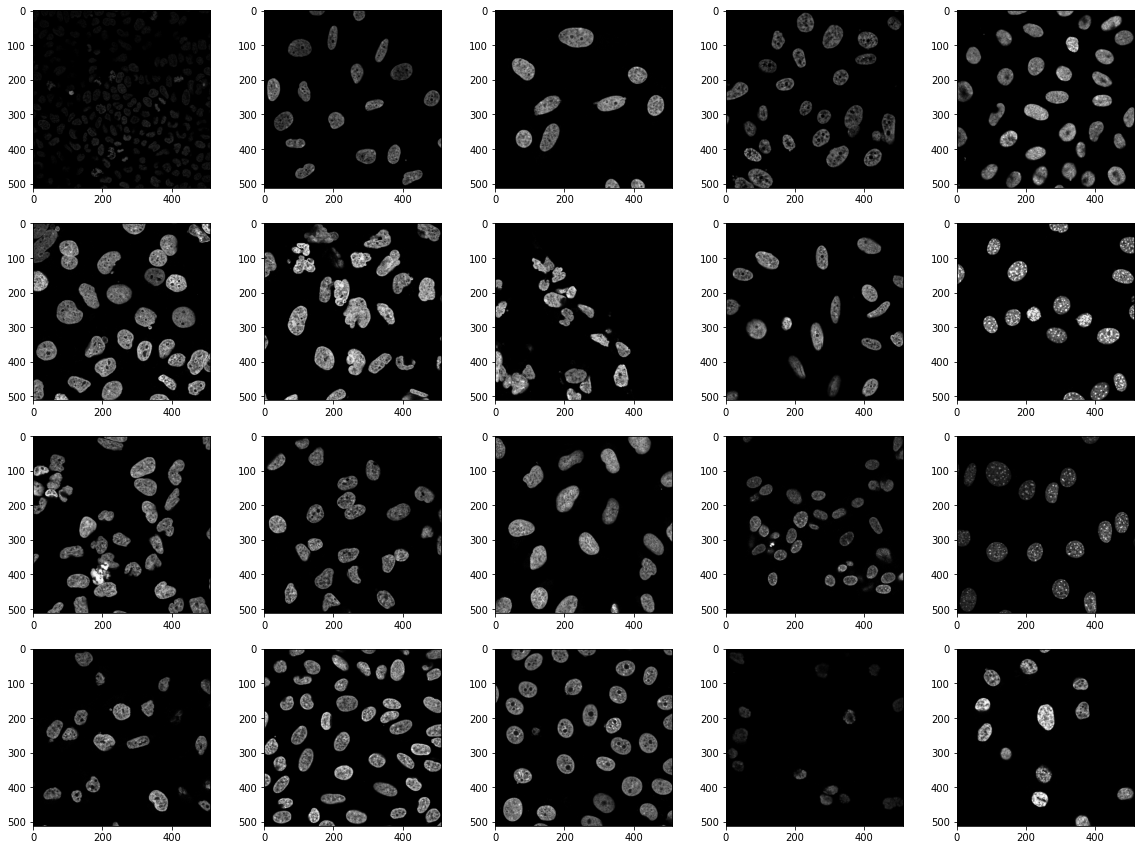

In [10]:
IDs = df_csv['Id']
plt.figure(figsize=(20, 15))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    for color in ['red', 'green', 'blue']:
        image_path = "train/{}_{}.png".format(str(IDs[i]), color)
        image = cv2.imread(image_path)
        plt.imshow(image)
plt.show()


##Preprocessing

In [11]:
def reszie_and_scale_image(img, target_size):
  img = cv2.resize(img, target_size)
  img = img/255
  return img

In [12]:
def read_img(paths):
  red = cv2.imread(paths[0], 0)
  red = reszie_and_scale_image(red, (90, 90))
  blue = cv2.imread(paths[1], 0)
  blue = reszie_and_scale_image(blue, (90, 90))
  yellow = cv2.imread(paths[2])
  yellow = reszie_and_scale_image(yellow, (90, 90))
  green = cv2.imread(paths[3], 0)
  green = reszie_and_scale_image(green, (90, 90))
  return np.array([np.stack(
      (red, green, blue), -1
  ), yellow])

In [13]:
images = []
list_images = df_csv['Id'][0:1001]
for img in list_images:
    paths = ["train/{}_{}.png".format(str(img), channel) for channel in ["red", "blue", "yellow", "green"]]
    image = read_img(paths)
    images.append(image)


In [15]:
len(images)
images = np.asarray(images)


In [16]:

images.shape
     

(1001, 2, 90, 90, 3)

In [17]:

target_now = np.zeros((len(images), 28), dtype=int)
target_now.shape

(1001, 28)

In [18]:
targets = df_csv['Target'][0:1001]
for index, tar in enumerate(targets):
  ids = tar.split()
  for id in ids:
    target_now[index, int(id)] = 1

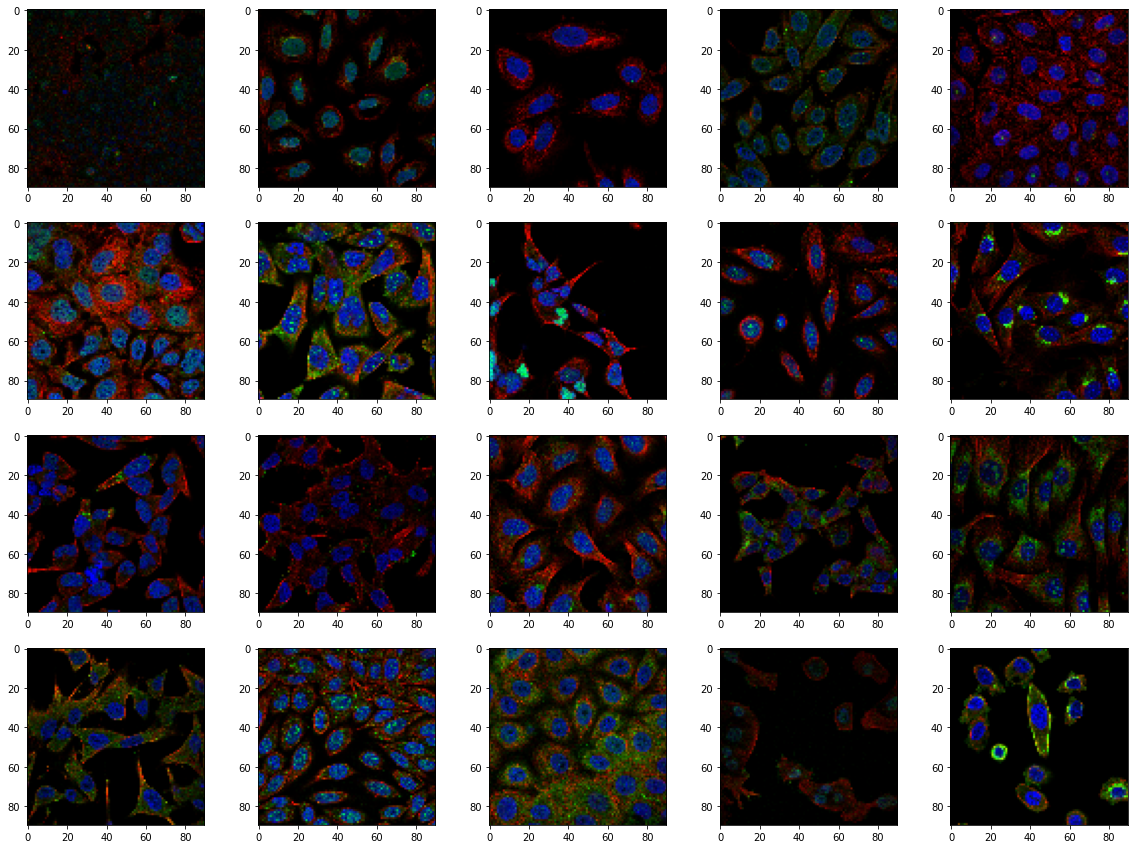

In [22]:

plt.figure(figsize = (20, 15))
for i in range(20):
  plt.subplot(4, 5, i + 1)
  plt.imshow(images[i][0])
plt.show()


##Model Building


In [19]:
DenseNet_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet',
                                                   input_shape = (90, 90, 3))
for layer in DenseNet_model.layers:
  layer.trainable = True  
  
model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(
        DenseNet_model, 
        input_shape = (2, 90, 90, 3)
    ),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dropout(0.5)
    ),
    tf.keras.layers.TimeDistributed(
        tf.keras.layers.GlobalAveragePooling2D()
    ),
    tf.keras.layers.GlobalAveragePooling1D(name = "GlobalAveragePooling1D"),
    tf.keras.layers.BatchNormalization(name = "BatchNormalization"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation = "relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(28, activation="sigmoid")
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001), loss = "binary_crossentropy" ,
              metrics = ["binary_accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 2, 2, 2, 1920)    18321984  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 2, 2, 2, 1920)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 2, 1920)          0         
 tributed)                                                       
                                                                 
 GlobalAveragePooling1D (Glo  (None, 1920)             0         
 balAveragePooling1D)                                            
                                                                 
 BatchNormalization (BatchNo  (None, 1920)             7

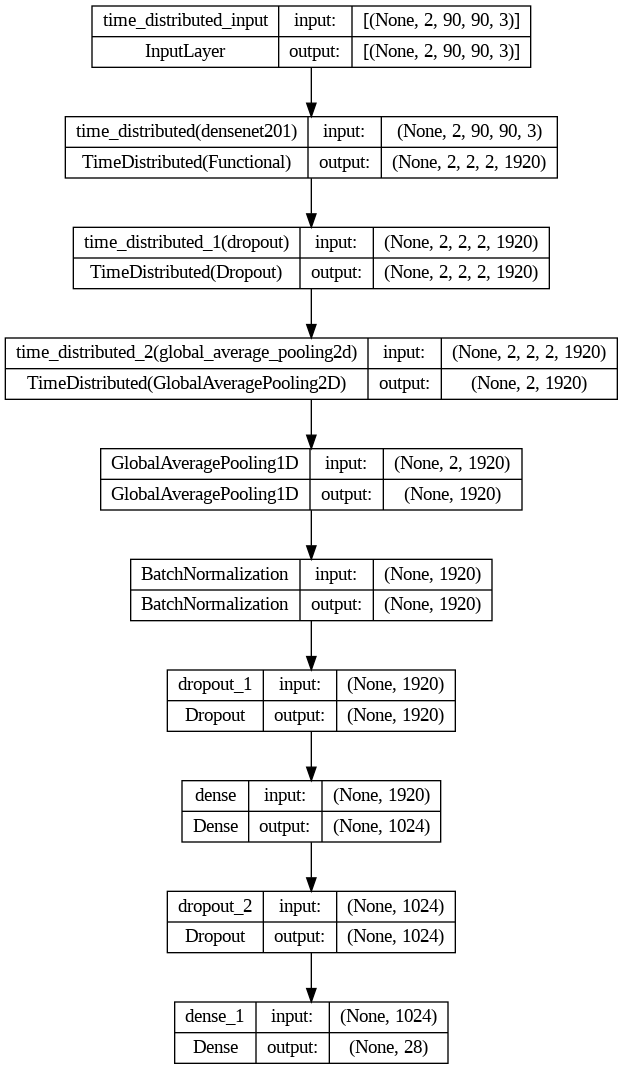

In [20]:

tf.keras.utils.plot_model(model, show_shapes=True,)

In [21]:
history = model.fit(
    images, target_now, epochs = 10, batch_size = 32,
          validation_split = 0.1,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                  patience= 1),
              tf.keras.callbacks.EarlyStopping(patience = 7, monitor = 'val_loss', mode = 'min', restore_best_weights=True)]
)
     

Epoch 1/10
29/29 [==============================] - 157s 718ms/step - loss: 0.9055 - binary_accuracy: 0.5094 - val_loss: 0.6802 - val_binary_accuracy: 0.5690 - lr: 1.0000e-05
Epoch 2/10
29/29 [==============================] - 9s 299ms/step - loss: 0.8537 - binary_accuracy: 0.5327 - val_loss: 0.6655 - val_binary_accuracy: 0.5873 - lr: 1.0000e-05
Epoch 3/10
29/29 [==============================] - 9s 299ms/step - loss: 0.8133 - binary_accuracy: 0.5599 - val_loss: 0.6470 - val_binary_accuracy: 0.6181 - lr: 1.0000e-05
Epoch 4/10
29/29 [==============================] - 9s 296ms/step - loss: 0.7617 - binary_accuracy: 0.5901 - val_loss: 0.6196 - val_binary_accuracy: 0.6588 - lr: 1.0000e-05
Epoch 5/10
29/29 [==============================] - 9s 301ms/step - loss: 0.7200 - binary_accuracy: 0.6106 - val_loss: 0.5974 - val_binary_accuracy: 0.6984 - lr: 1.0000e-05
Epoch 6/10
29/29 [==============================] - 9s 303ms/step - loss: 0.6783 - binary_accuracy: 0.6374 - val_loss: 0.5773 - val_b

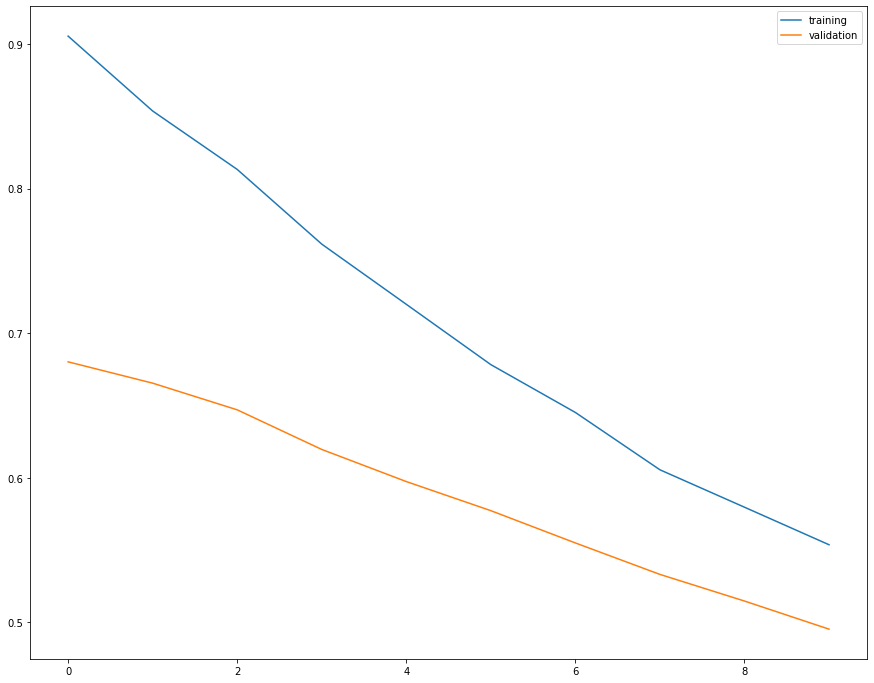

In [25]:
epoch = np.arange(10)
plt.figure(figsize=(15,12))
plt.plot(epoch, history.history["loss"], label="training")
plt.plot(epoch, history.history["val_loss"],label="validation")
plt.legend()
plt.show()

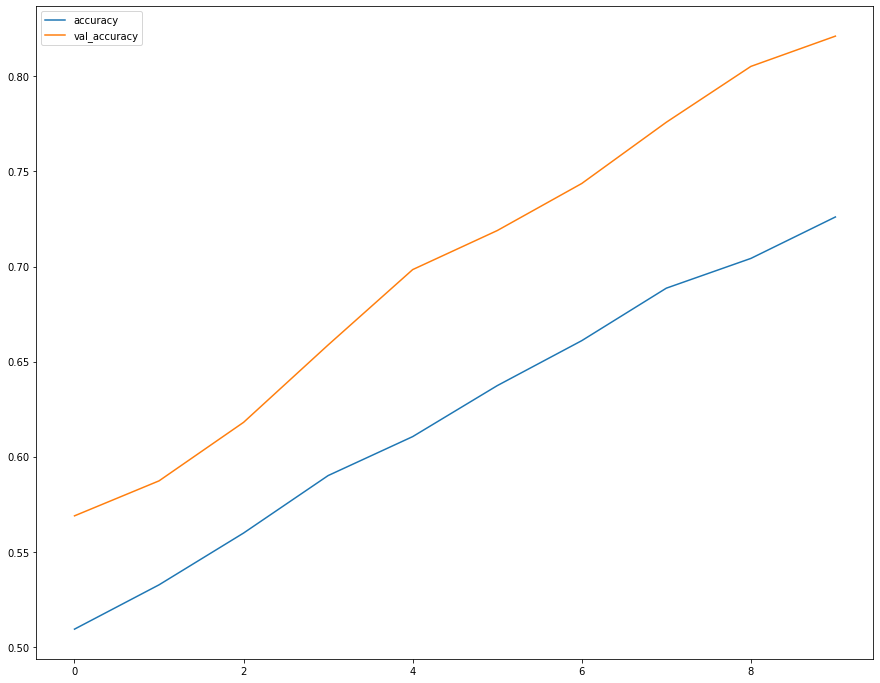

In [26]:
epoch = np.arange(10)
plt.figure(figsize=(15,12))
plt.plot(epoch, history.history["binary_accuracy"], label="accuracy")
plt.plot(epoch, history.history["val_binary_accuracy"],label="val_accuracy")
plt.legend()
plt.show()